# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,auc,accuracy_score,classification_report,precision_score,recall_score,f1_score

from sklearn.naive_bayes import MultinomialNB

from prettytable import PrettyTable

from tqdm import tqdm

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [4]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [7]:
final = final.sort_values(['Time'], axis = 0)

In [8]:
final = final.head(100000)
final_x = final['Text']
final_y = final['Score']

#  [3] Preprocessing

Steps will involve:

- Stopword removal
- Stemming
- Punctuation removal

In [9]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# Code to remove URLs,HTML tags, words with numbers and special characters, making words lower
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_x):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:57<00:00, 1732.59it/s]


In [12]:
final_x= preprocessed_reviews

In [13]:
# Let's split final_x and final_y datsets into train and test sets
X_train = final_x[:80000]
X_test = final_x[80000:]
y_train = final_y[:80000]
y_test = final_y[80000:]

# Applying Multinomial Naive Bayes

## [4.1] Naive bayes algo implementation on BOW

In [14]:
count_vec = CountVectorizer(max_features=5000)
bow_X_train = count_vec.fit_transform(X_train)
bow_X_test = count_vec.transform(X_test)

In [15]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
est = MultinomialNB(class_prior = [0.5,0.5])
param_grid = { 'alpha':alpha}
grid = GridSearchCV(estimator=est,param_grid=param_grid, scoring = 'roc_auc',cv=10, n_jobs= -1)
grid.fit(bow_X_train,y_train)
train_acc1 = grid.best_score_*100
al1 = grid.best_params_.get('alpha')
print('The best alpha:',al1)
print('Accuracy on Training data:',train_acc1,'%')


The best alpha: 1
Accuracy on Training data: 91.03445940935924 %


In [16]:
grid.cv_results_

{'mean_fit_time': array([0.12497199, 0.13122008, 0.14840267, 0.14059293, 0.13434446,
        0.13121972, 0.12965734, 0.13746848, 0.13121958]),
 'mean_score_time': array([0.0124975 , 0.01249743, 0.01249738, 0.00781052, 0.00937235,
        0.01405942, 0.01406057, 0.00937328, 0.00468659]),
 'mean_test_score': array([0.90613906, 0.90699971, 0.90794926, 0.90891198, 0.91034459,
        0.90331396, 0.74051724, 0.54768228, 0.48935779]),
 'mean_train_score': array([0.9339973 , 0.93392658, 0.93380352, 0.9335641 , 0.93271787,
        0.92217362, 0.75057886, 0.54945454, 0.49022653]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000},
  {'alpha': 10000}],

In [17]:
mean_train_score = []
for i in grid.cv_results_['mean_train_score']:
    mean_train_score.append(i*100)

In [18]:
mean_train_score

[93.39972985513987,
 93.3926575899755,
 93.38035202437872,
 93.35641022256199,
 93.27178675609638,
 92.21736152785505,
 75.05788569345964,
 54.94545446876734,
 49.02265273341882]

In [19]:
mean_test_score = []
for j in grid.cv_results_['mean_test_score']:
    mean_test_score.append(j*100)

In [20]:
mean_test_score

[90.61390593623938,
 90.69997052129615,
 90.79492578582293,
 90.89119774835716,
 91.03445940935924,
 90.33139622367639,
 74.05172424947342,
 54.768227815448334,
 48.93577902032044]

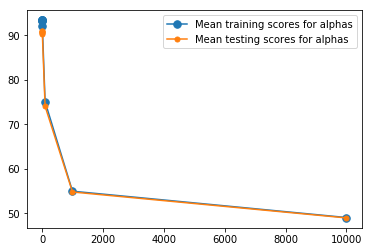

In [21]:
plt.plot(alpha,mean_train_score,marker='.',markersize = 15,label='Mean training scores for alphas')
plt.plot(alpha,mean_test_score,marker='o', markersize= 5, label = 'Mean testing scores for alphas')
plt.legend(loc='upper right')
plt.show()

In [22]:
est_opt1 = MultinomialNB(alpha=al1)
est_opt1.fit(bow_X_train,y_train)
predict = est_opt1.predict(bow_X_test)

## Measure of effectiveness

In [23]:
test_acc1 = accuracy_score(y_test,predict)*100
precision1 = precision_score(y_test,predict)*100
recall1 = recall_score(y_test,predict)*100
f11 = f1_score(y_test,predict)*100
print('Accuracy on test data:',test_acc1,'%')
print('Precision Score:',precision1,'%')
print('Recall Score:',recall1,'%')
print('F1 score:',f11,'%')

cm = confusion_matrix(y_test,predict)
print('Confusion Matrix:','\n',cm)

Accuracy on test data: 90.185 %
Precision Score: 95.40644398462904 %
Recall Score: 93.15400600323251 %
F1 score: 94.26677180992435 %
Confusion Matrix: 
 [[ 1899   777]
 [ 1186 16138]]


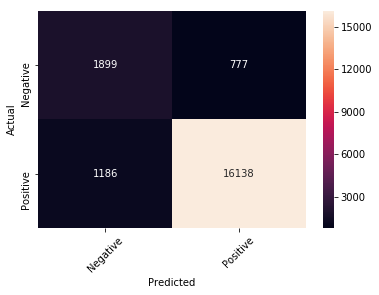

In [24]:
cm_df = pd.DataFrame(cm, index = ['Negative','Positive'])
sns.heatmap(cm_df, annot = True,fmt = 'd')
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      2676
           1       0.95      0.93      0.94     17324

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.78      0.82      0.80     20000
weighted avg       0.91      0.90      0.90     20000



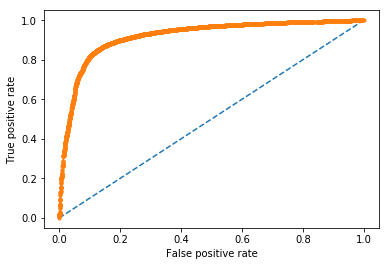

In [26]:
#Plotting Roc curve

y_pred = est_opt1.predict_proba(bow_X_test)[:,1]

fpr,tpr,threshold = roc_curve(y_test,y_pred)

plt.plot([0,1],[0,1],linestyle = '--')
plt.plot(fpr,tpr,marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [27]:
roc_score1 = roc_auc_score(y_test,y_pred)
print(roc_score1)

0.919653140238673


In [28]:
neg_imp_word = list(map(abs,est_opt1.feature_log_prob_))[0].argsort()[0:10]
pos_imp_word = list(map(abs,est_opt1.feature_log_prob_))[1].argsort()[0:10]

### [4.1.1] Top 10 important features of positive class

In [29]:
print('Below are the Top 10 Positive impacting words:')
pos1 = []
for i in pos_imp_word:
    for j in count_vec.vocabulary_:
        if count_vec.vocabulary_[j] == i:
            pos1.append(j)
print(pos1)

Below are the Top 10 Positive impacting words:
['not', 'like', 'good', 'great', 'tea', 'one', 'taste', 'flavor', 'product', 'love']


### [4.1.2] Top 10 important features of negative class

In [30]:
print('Below are the Top 10 Negative impacting words: ')
neg1 = []
for i in neg_imp_word:
    for j in count_vec.vocabulary_:
        if count_vec.vocabulary_[j] == i:
            neg1.append(j)
print(neg1)

Below are the Top 10 Negative impacting words: 
['not', 'like', 'product', 'taste', 'would', 'one', 'good', 'no', 'flavor', 'tea']


## [4.2] Naive bayes algo implementation on TFIDF

In [31]:
tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf_X_train = tfidf_vec.fit_transform(X_train)
tfidf_X_test = tfidf_vec.transform(X_test)

In [32]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
est = MultinomialNB(class_prior = [0.5,0.5])
param_grid = { 'alpha':alpha}
grid = GridSearchCV(estimator=est,param_grid=param_grid, scoring = 'roc_auc',cv=10, n_jobs= -1)
grid.fit(tfidf_X_train,y_train)
train_acc2 = grid.best_score_*100
al2 = grid.best_params_.get('alpha')
print('The best alpha:',al2)
print('Accuracy on Training data:',train_acc2,'%')

The best alpha: 0.1
Accuracy on Training data: 92.23124992729143 %


In [33]:
grid.cv_results_

{'mean_fit_time': array([0.11614771, 0.12809553, 0.12184703, 0.13278198, 0.1299963 ,
        0.13122084, 0.13278201, 0.12184758, 0.11872199]),
 'mean_score_time': array([0.00781074, 0.00937347, 0.00624855, 0.01093528, 0.01093578,
        0.01249635, 0.01093507, 0.01249716, 0.00781038]),
 'mean_test_score': array([0.91780182, 0.91884827, 0.9201667 , 0.9223125 , 0.92215364,
        0.86755657, 0.72023386, 0.6388261 , 0.60761955]),
 'mean_train_score': array([0.94589006, 0.94583293, 0.94571585, 0.94532928, 0.94008739,
        0.8813211 , 0.72596093, 0.64152472, 0.60975908]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000},
  {'alpha': 10000}],

In [34]:
mean_train_score = []
for i in grid.cv_results_['mean_train_score']:
    mean_train_score.append(i*100)

In [35]:
mean_test_score = []
for j in grid.cv_results_['mean_test_score']:
    mean_test_score.append(j*100)

In [36]:
mean_test_score

[91.78018162909734,
 91.88482701201886,
 92.01666980375109,
 92.23124992729143,
 92.21536357329208,
 86.75565731204598,
 72.02338629838847,
 63.882610225162274,
 60.76195536341158]

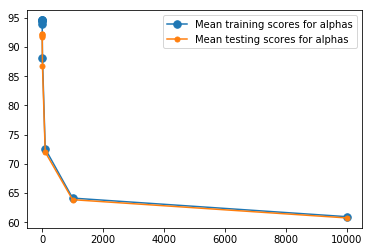

In [37]:
plt.plot(alpha,mean_train_score,marker='.',markersize = 15,label='Mean training scores for alphas')
plt.plot(alpha,mean_test_score,marker='o', markersize= 5, label = 'Mean testing scores for alphas')
plt.legend(loc='upper right')
plt.show()

In [38]:
est_opt2 = MultinomialNB(alpha=al2)
est_opt2.fit(tfidf_X_train,y_train)
predict = est_opt2.predict(tfidf_X_test)

## Measure of effectiveness

In [39]:
test_acc2 = accuracy_score(y_test,predict)*100
precision2 = precision_score(y_test,predict)*100
recall2 = recall_score(y_test,predict)*100
f12 = f1_score(y_test,predict)*100

print('Accuracy on test data:',test_acc2,'%')
print('Precision score:',precision2,'%')
print('Recall score:',recall2,'%')
print('F1 score:',f12,'%')

cm = confusion_matrix(y_test,predict)
print('Confusion Matrix:','\n',cm)

Accuracy on test data: 88.805 %
Precision score: 88.8248314201884 %
Recall score: 99.60748095128146 %
F1 score: 93.907648771462 %
Confusion Matrix: 
 [[  505  2171]
 [   68 17256]]


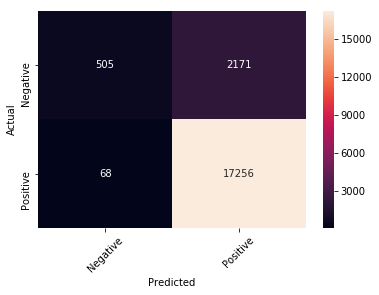

In [40]:
cm_df = pd.DataFrame(cm, index = ['Negative','Positive'])
sns.heatmap(cm_df, annot = True,fmt = 'd')
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

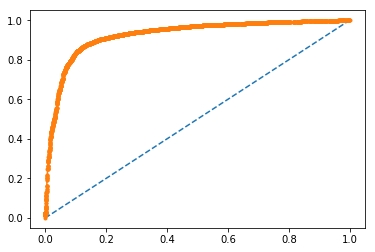

In [41]:
#plotting Roc curve

y_pred = est_opt2.predict_proba(bow_X_test)[:,1]
fpr,tpr,threshold = roc_curve(y_test,y_pred)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr,marker='.')
plt.show()

In [42]:
roc_score2 = roc_auc_score(y_test,y_pred)
print(roc_score2)

0.9262057803460227


In [43]:
neg_imp_word = list(map(abs,est_opt2.feature_log_prob_))[0].argsort()[0:10]
pos_imp_word = list(map(abs,est_opt2.feature_log_prob_))[1].argsort()[0:10]

### [4.2.1] Top 10 important features of positive class

In [44]:
print('Below are the Top 10 positive impacting words:')
pos2 = []
for i in pos_imp_word:
    for j in tfidf_vec.vocabulary_:
        if tfidf_vec.vocabulary_[j] == i:
            pos2.append(j)
print(pos2)

Below are the Top 10 positive impacting words:
['not', 'great', 'tea', 'good', 'like', 'love', 'product', 'taste', 'coffee', 'one']


### [4.2.2] Top 10 important features of negative class

In [45]:
print('Below are the Top 10 negative impacting words:')
neg2 = []
for i in neg_imp_word:
    for j in tfidf_vec.vocabulary_:
        if tfidf_vec.vocabulary_[j] == i:
            neg2.append(j)
print(neg2)

Below are the Top 10 negative impacting words:
['not', 'like', 'product', 'taste', 'would', 'one', 'no', 'flavor', 'good', 'coffee']


## Formatting using Pretty table:

In [46]:
x = PrettyTable()

model1 = 'NB using BOW'
model2 = 'NB using TFIDF'

x.field_names = ['Model','Alpha','Train Acc(%)','Test Acc(%)','AUC Score','Precision(%)','Recall(%)','F1 score(%)']

train_acc1 = np.around(train_acc1,decimals=2)
train_acc2 = np.around(train_acc2,decimals= 2)

test_acc1 = np.around(test_acc1,decimals=2)
test_acc2 = np.around(test_acc2,decimals=2)

roc_score1 = np.around(roc_score1,decimals=2)
roc_score2 = np.around(roc_score2,decimals=2)

precision1 = np.around(precision1,decimals=2)
precision2 = np.around(precision2,decimals=2)

recall1 = np.around(recall1,decimals=2)
recall2 = np.around(recall2,decimals=2)

f11 = np.around(f11,decimals=2)
f12 = np.around(f12,decimals=2)

x.add_row([model1,al1,train_acc1,test_acc1,roc_score1,precision1,recall1,f11])
x.add_row([model2,al2,train_acc2,test_acc2,roc_score2,precision2,recall2,f12])

print(x)

+----------------+-------+--------------+-------------+-----------+--------------+-----------+-------------+
|     Model      | Alpha | Train Acc(%) | Test Acc(%) | AUC Score | Precision(%) | Recall(%) | F1 score(%) |
+----------------+-------+--------------+-------------+-----------+--------------+-----------+-------------+
|  NB using BOW  |   1   |    91.03     |    90.18    |    0.92   |    95.41     |   93.15   |    94.27    |
| NB using TFIDF |  0.1  |    92.23     |     88.8    |    0.93   |    88.82     |   99.61   |    93.91    |
+----------------+-------+--------------+-------------+-----------+--------------+-----------+-------------+


## Summary and Inference:

- I have considered 100k data after time based sorting.
- I have done time based splitting with 80:20 ratio for train and test respectively.
- In BOW model, I got optimal alpha as 1 where in TFIDF model the optimal alpha was found as 0.1.
- AUC score for both the models are almost same. F1 score of NB using BOW is higher compared to NB using TFIDF.
- PrettyTable has been used to make a tabular summary of all the metrices for both models.
- However during observation,I found that in above 2 models, top 10 positive and negative words which were impacting the models   were semantically similar. The cause which i am guessing is: all these words were mostly repeated in both the classes.